In [1]:
import iris
import os
import matplotlib.pyplot as plt
import iris.plot as iplt
import cartopy.crs as ccrs
import datetime as dt
os.chdir("/home/548/eh6215/Desktop/python/BARPA_evaluation/emma/lib")
from plotting_functions import bias_plots as bias_plots2

In [2]:
alpha_w = iris.coords.AuxCoord(1/1000.,units='m**3*kg**-1')
cmip_info = {"ACCESS-CM2":("CSIRO-ARCCSS","r4i1p1f1"),
             "ACCESS-ESM1-5":('CSIRO','r6i1p1f1'),
             "NorESM2-MM":('NCC','r1i1p1f1'),
             "CNRM-ESM2-1":('CNRM-CERFACS','r1i1p1f2'),
             "EC-Earth3":('EC-Earth-Consortium','r1i1p1f1'),
             "MRI-ESM2-0":('MRI','r1i1p1f1')}

In [3]:
def load_cmip6(scenario,model,stream,var,t_s,t_e,Constraints,template=None,lapse=None,regrid_method=iris.analysis.Linear(),callback=None):
    group,rev  = cmip_info[model]
    if scenario == 'historical':
        mip = "CMIP"
    else:
        mip = "ScenarioMIP"
    path = "/g/data/r87/DRSv3/CMIP6/{mip}/{group}/{model}/{scenario}/{rev}/{stream}/{var}/gn/latest/".format(mip=mip,scenario=scenario,rev=rev,stream=stream,var=var,group=group,model=model)
    filepart = "{var}_{stream}_{model}_{scenario}_{rev}_".format(mip=mip,scenario=scenario,rev=rev,stream=stream,var=var,group=group,model=model)
    try:
        files = [f for f in os.listdir(path) if filepart in f]
    except:
        path = path.replace('/gn/latest/','')
        files = [f for f in os.listdir(path)][0]
        path = path+"/"+files
        files = [f for f in os.listdir(path)][0]
        path = path+"/"+files
        files = [f for f in os.listdir(path) if filepart in f]
    starts = [f.split("_")[-1].split("-")[0] for f in files]
    ends = [f.split("_")[-1].split("-")[1] for f in files]
    starts = [dt.datetime(int(x[:4]),int(x[4:6]),1) for x in starts]
    ends = [dt.datetime(int(x[:4]),int(x[4:6]),1) for x in ends]
    files = [ os.path.join(path,f) for (i,f) in enumerate(files) if ((t_e  - starts[i]).days >0  and (ends[i] - t_s).days >= 0) ]
    ct = iris.Constraint(time = lambda t: ((dt.datetime(t.point.year,t.point.month,1) - t_s).days >= 0) and ((dt.datetime(t.point.year,t.point.month,1) - t_e).days < 0))
    data = iris.load(files,Constraints&ct)
    iris.util.equalise_attributes(data)
    data=data.concatenate_cube()
    if not template is None:
        data.coord('longitude').coord_system = template.coord('longitude').coord_system
        data.coord('latitude').coord_system = template.coord('latitude').coord_system
        data = data.regrid(template,regrid_method)
        if lapse is not None:
            topo_CMIP = iris.load_cube("/g/data/r87/DRSv3/CMIP6/{mip}/{group}/{model}/{scenario}/{rev}/fx/orog/gn/latest/orog_fx_{model}_{scenario}_{rev}_gn.nc".format(mip=mip,scenario=scenario,rev=rev,stream=stream,var=var,group=group,model=model),Constraints,callback)
            topo_CMIP.coord('longitude').coord_system = template.coord('longitude').coord_system
            topo_CMIP.coord('latitude').coord_system = template.coord('latitude').coord_system
            topo_CMIP = topo_CMIP.regrid(template,regrid_method)
            delta = (template - topo_CMIP)*lapse
            delta.convert_units(data.units)
            data.data = data.data + delta.data
    if var=='pr':
        name = data.name()
        data = data*alpha_w
        data.rename(name)
    return data

In [4]:
TA = {}
T1000 = {}
TS = {}
orog = {}
cx2=iris.Constraint(longitude=lambda x:-180<=x<=360)
cy2=iris.Constraint(latitude=lambda y:-90<=y<=90)

def callback(cube,field,filename):
    cube1 = cube.extract(iris.Constraint(longitude=lambda x: x>=0))
    cube2 = cube.extract(iris.Constraint(longitude=lambda x: x<0))
    cube2.coord('longitude').points = cube2.coord('longitude').points + 360
    if cube2.coord('longitude').has_bounds():
        cube2.coord('longitude').bounds = cube2.coord('longitude').bounds + 360
    return iris.cube.CubeList([cube1,cube2]).concatenate_cube()

In [8]:

import warnings
def fxn():
    warnings.warn("user", UserWarning)

warnings.simplefilter("ignore")
fxn()

for i,model in enumerate(cmip_info.keys()):
        for scen in ['historical']:
      #      if model not in TA.keys():
                T1000[model] = load_cmip6(scen,model,"Amon","ta",dt.datetime(1979,1,1),dt.datetime(2015,1,1),cx2&cy2)#callback=callback)
                TS[model] = load_cmip6(scen,model,"Amon","ts",dt.datetime(1979,1,1),dt.datetime(2015,1,1),cx2&cy2)#callback=callback)
                TA[model] = load_cmip6(scen,model,"Amon","tas",dt.datetime(1979,1,1),dt.datetime(2015,1,1),cx2&cy2)#callback=callback)

In [ ]:
obs = iris.load("/g/data/rt52/era5/single-levels/monthly-averaged/sst/*/sst_era5_moda_sfc_*.nc",cx2&cy2)

In [13]:
#iris.util.equalise_attributes(obs)
#obs = obs.concatenate_cube()
obs=obs.collapsed('time',iris.analysis.MEAN)

In [74]:
TA
TS

{'ACCESS-CM2': <iris 'Cube' of air_temperature / (K) (time: 120; latitude: 144; longitude: 192)>,
 'ACCESS-ESM1-5': <iris 'Cube' of air_temperature / (K) (time: 120; latitude: 145; longitude: 192)>,
 'NorESM2-MM': <iris 'Cube' of air_temperature / (K) (time: 120; latitude: 192; longitude: 288)>,
 'EC-Earth3': <iris 'Cube' of air_temperature / (K) (time: 120; latitude: 256; longitude: 512)>,
 'MRI-ESM2-0': <iris 'Cube' of air_temperature / (K) (time: 120; latitude: 160; longitude: 320)>,
 'CNRM-ESM2-1': <iris 'Cube' of air_temperature / (K) (time: 120; latitude: 128; longitude: 256)>}

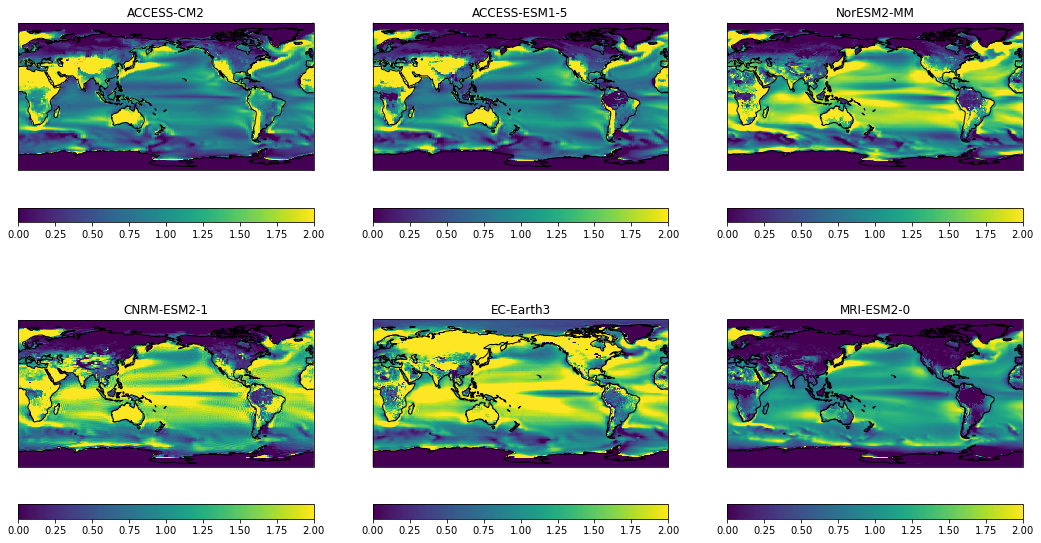

In [16]:
plt.figure(figsize=(18,10))
for i,model in enumerate(TA.keys()):
    ax=plt.subplot(2,3,i+1,projection=ccrs.PlateCarree(180))
    iplt.pcolormesh((TS[model]-TA[model]).collapsed('time',iris.analysis.MEAN),vmin=0,vmax=2,cmap='viridis')
    plt.title(model)
    plt.colorbar(orientation='horizontal')
    ax.coastlines()

In [46]:
TA

{'ACCESS-CM2': <iris 'Cube' of surface_temperature / (K) (time: 120; latitude: 144; longitude: 192)>,
 'ACCESS-ESM1-5': <iris 'Cube' of surface_temperature / (K) (time: 120; latitude: 145; longitude: 192)>,
 'NorESM2-MM': <iris 'Cube' of surface_temperature / (K) (time: 120; latitude: 192; longitude: 288)>}

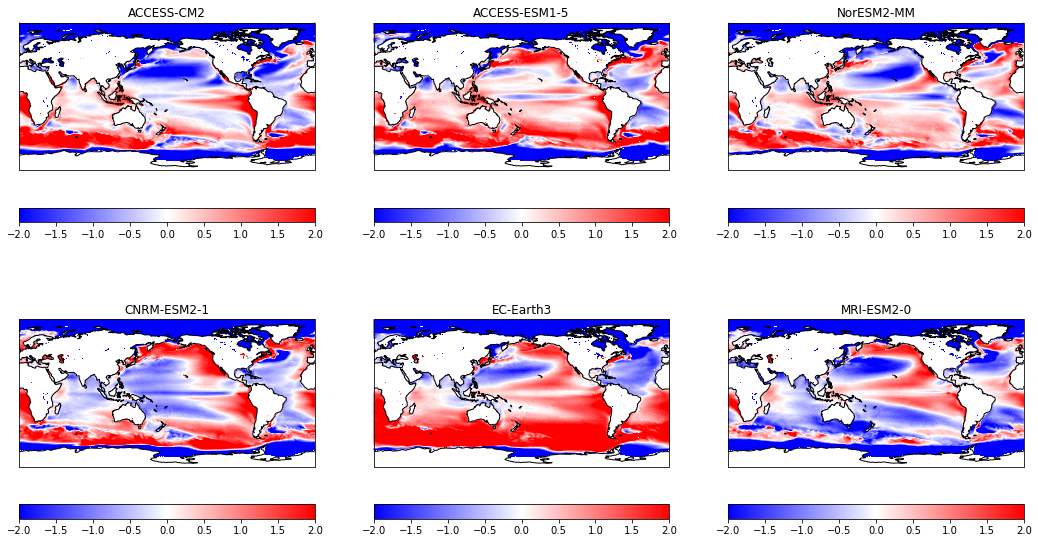

In [17]:
plt.figure(figsize=(18,10))
for i,model in enumerate(TA.keys()):
    ax=plt.subplot(2,3,i+1,projection=ccrs.PlateCarree(180))
    ts = TS[model].collapsed('time',iris.analysis.MEAN).regrid(obs,iris.analysis.Linear())
    iplt.pcolormesh(ts- obs,vmin=-2,vmax=2,cmap='bwr')
    plt.title(model)
    plt.colorbar(orientation='horizontal')
    ax.coastlines()

In [105]:
T1000['ACCESS-CM2'].coord('air_pressure')

DimCoord(array([100000.,  92500.,  85000.,  70000.,  60000.,  50000.,  40000.,
        30000.,  25000.,  20000.,  15000.,  10000.,   7000.,   5000.,
         3000.,   2000.,   1000.,    500.,    100.]), bounds=array([[ 1.0375e+05,  9.6250e+04],
       [ 9.6250e+04,  8.8750e+04],
       [ 8.8750e+04,  7.7500e+04],
       [ 7.7500e+04,  6.5000e+04],
       [ 6.5000e+04,  5.5000e+04],
       [ 5.5000e+04,  4.5000e+04],
       [ 4.5000e+04,  3.5000e+04],
       [ 3.5000e+04,  2.7500e+04],
       [ 2.7500e+04,  2.2500e+04],
       [ 2.2500e+04,  1.7500e+04],
       [ 1.7500e+04,  1.2500e+04],
       [ 1.2500e+04,  8.5000e+03],
       [ 8.5000e+03,  6.0000e+03],
       [ 6.0000e+03,  4.0000e+03],
       [ 4.0000e+03,  2.5000e+03],
       [ 2.5000e+03,  1.5000e+03],
       [ 1.5000e+03,  7.5000e+02],
       [ 7.5000e+02,  3.0000e+02],
       [ 3.0000e+02, -1.0000e+02]]), standard_name='air_pressure', units=Unit('Pa'), long_name='pressure', var_name='plev', attributes={'positive': 'down'})

In [115]:
BARPA_T = iris.load("/g/data/tp28/dev/barpa/trials/chs548/cg282_norESM_debug/20140101T0000Z/nc/MDL15M1/*-v1-2014010*",cx&cy)
BARPA_T10 = iris.load("/g/data/tp28/dev/barpa/trials/eh6215/cg282_NorESM2_2010/20100101T0000Z/nc/MDL15M1/*-v1-2010010*",cx&cy)
BARPA_TA = iris.load("/g/data/tp28/dev/barpa/prod/eh6215/cg282_ACCESS-CM2_ssp370*/20140101T0000Z/nc/MDL15M1/*-v1-2014010*",cx&cy)

iris.util.equalise_attributes(BARPA_T10)
BARPA_T10 = BARPA_T10.concatenate_cube()
iris.util.equalise_attributes(BARPA_TA)
BARPA_TA = BARPA_TA.concatenate_cube()
iris.util.equalise_attributes(BARPA_T)
BARPA_T = BARPA_T.concatenate_cube()

NameError: name 'cx' is not defined

In [14]:
obs

<iris 'Cube' of Sea surface temperature / (K) (latitude: 721; longitude: 1440)>